## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_wavelet_full_pastis.ipynb


In [ ]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\pastis\\full\\wavelet\\gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:5]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 34762 CDFs


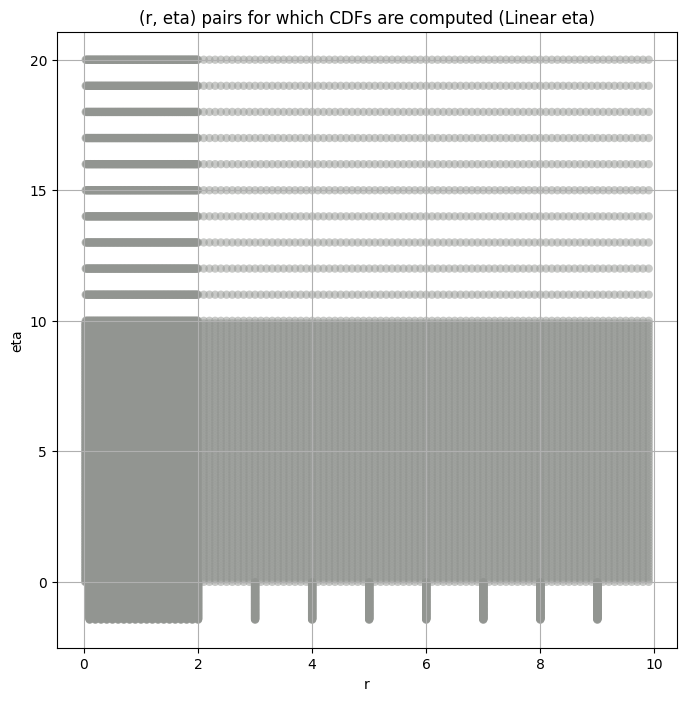

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, 0), <scipy.interpolate._fitpack2.Inter...",0.02,0.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,4.553186e+99,NaN
1,"((0.02, 0.1), <scipy.interpolate._fitpack2.Int...",0.02,0.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.560477e+100,NaN
2,"((0.02, 0.2), <scipy.interpolate._fitpack2.Int...",0.02,0.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,6.013272e+101,NaN
3,"((0.02, 0.3), <scipy.interpolate._fitpack2.Int...",0.02,0.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.824903e+102,NaN
4,"((0.02, 0.4), <scipy.interpolate._fitpack2.Int...",0.02,0.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.104347e+103,NaN


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [ ]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,1830.934600,1652.097700,2023.443800,2.933956,1.846394,4.126091,3180.0
3,587.781860,556.332100,620.660600,2.604501,2.026207,3.270645,12720.0
4,164.606740,154.984480,174.518840,3.278817,2.623241,4.093916,50880.0
5,37.863530,35.388520,40.433693,4.789257,3.843992,5.925406,203520.0
6,7.493805,6.929792,8.083941,6.740130,5.245897,8.892210,814080.0
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0
8,0.215883,0.196152,0.238341,12.285479,8.522737,23.484678,13025280.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr

augmented_var_df.to_csv(augmented_var_df_path)
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,1830.934600,1830.934570,1452.429077,1276.170166,1145.674072,1040.546997,878.686707,749.599243,645.658875,561.035522,489.759491,327.872131
3,587.781860,587.781860,541.575623,515.132324,493.123138,474.211823,442.020203,414.849426,391.358582,370.649902,351.753479,305.333282
4,164.606740,164.606735,159.676453,156.378769,153.571075,151.044083,146.518402,142.496201,138.862274,135.548203,132.480392,124.381584
5,37.863530,37.863529,37.043510,36.452328,35.938229,35.477501,34.660660,33.947586,33.302437,32.709419,32.163368,30.706472
6,7.493805,7.493805,7.288052,7.147865,7.028977,6.923156,6.736482,6.573743,6.427655,6.294827,6.172112,5.849967
7,1.386997,1.386997,1.341698,1.311312,1.285678,1.262962,1.223419,1.189016,1.158356,1.130504,1.104886,1.037957
8,0.215883,0.215883,0.206941,0.201541,0.197070,0.193155,0.186390,0.180575,0.175420,0.170760,0.166490,0.155441


####
Layer  2


100%|██████████| 34762/34762 [00:44<00:00, 783.66it/s] 


Finding Minimum after computing 34762 CDFs
2 0 0.016936870448775343 1830.9346


100%|██████████| 34762/34762 [00:25<00:00, 1351.00it/s]


Finding Minimum after computing 34762 CDFs
2 25 0.017616728219521982 1452.4291


100%|██████████| 34762/34762 [00:24<00:00, 1438.98it/s]


Finding Minimum after computing 34762 CDFs
2 50 0.027312266814269237 1276.1702
Number of samples: 3180, Without approximation : 3180.0


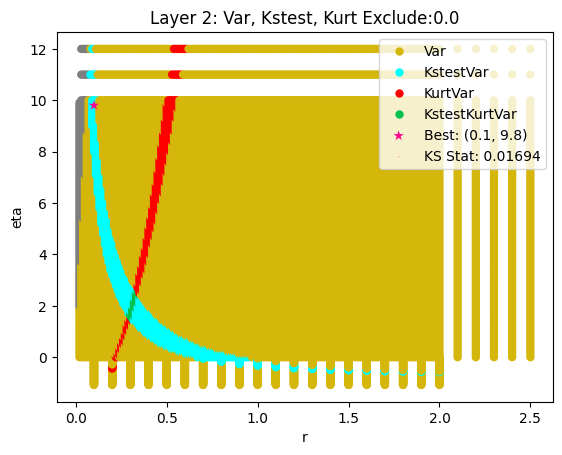

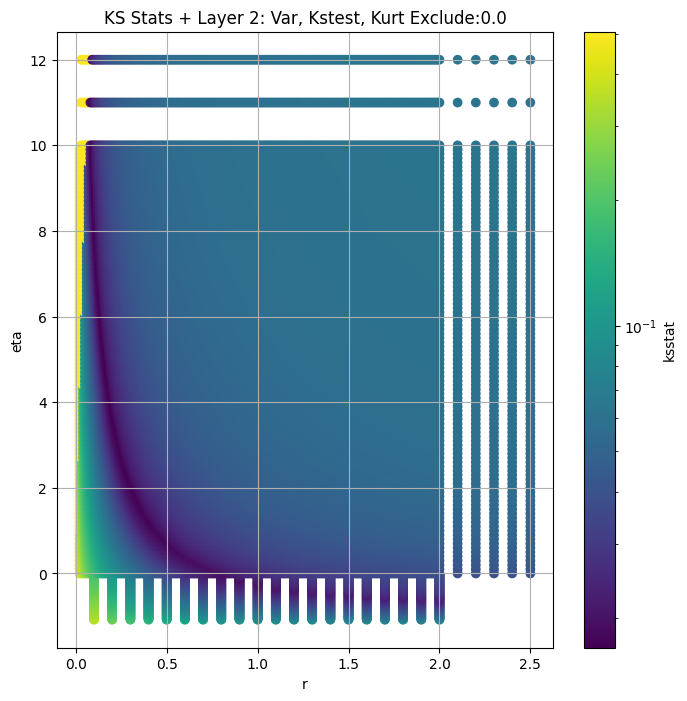

####
Layer  3


100%|██████████| 34762/34762 [02:31<00:00, 229.26it/s]


Finding Minimum after computing 34762 CDFs
3 0 0.004774822442595528 587.78186


100%|██████████| 34762/34762 [01:24<00:00, 409.23it/s]


Finding Minimum after computing 34762 CDFs
3 25 0.006796389431769523 541.5756


100%|██████████| 34762/34762 [00:54<00:00, 636.28it/s]


Finding Minimum after computing 34762 CDFs
3 50 0.008858275885730515 515.1323
Number of samples: 12720, Without approximation : 12720.0


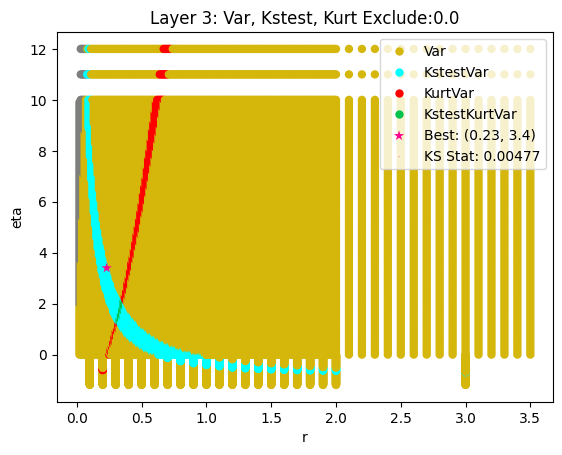

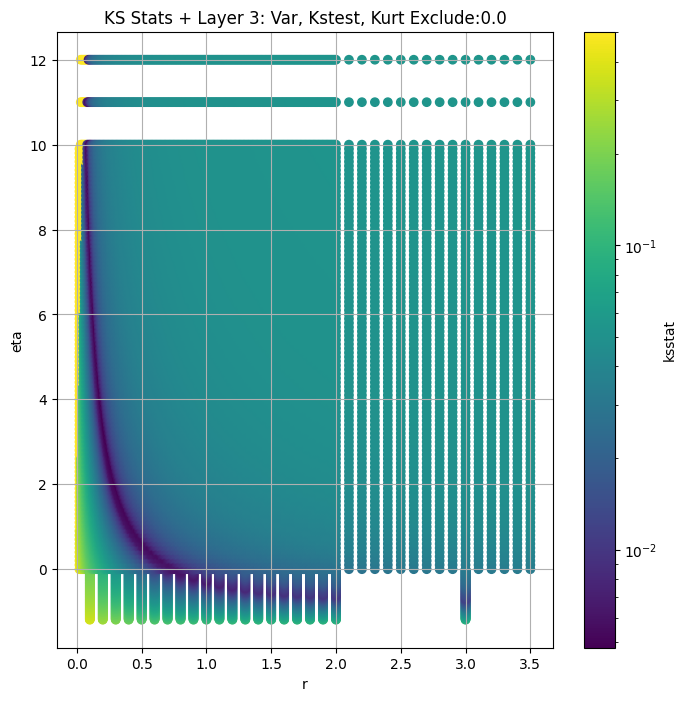

####
Layer  4


100%|██████████| 34762/34762 [03:31<00:00, 164.12it/s]


Finding Minimum after computing 34762 CDFs
4 0 0.004919686818396551 164.60674


100%|██████████| 34762/34762 [03:45<00:00, 154.50it/s]


Finding Minimum after computing 34762 CDFs
4 25 0.004879036489315092 159.67645


100%|██████████| 34762/34762 [04:41<00:00, 123.50it/s]


Finding Minimum after computing 34762 CDFs
4 50 0.005038087763519994 156.37877


100%|██████████| 34762/34762 [03:28<00:00, 166.58it/s]


Finding Minimum after computing 34762 CDFs
4 75 0.005611809681149826 153.57108
Number of samples: 50880, Without approximation : 50880.0


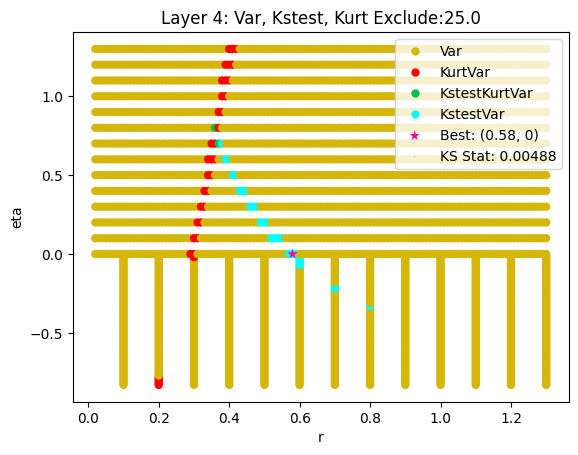

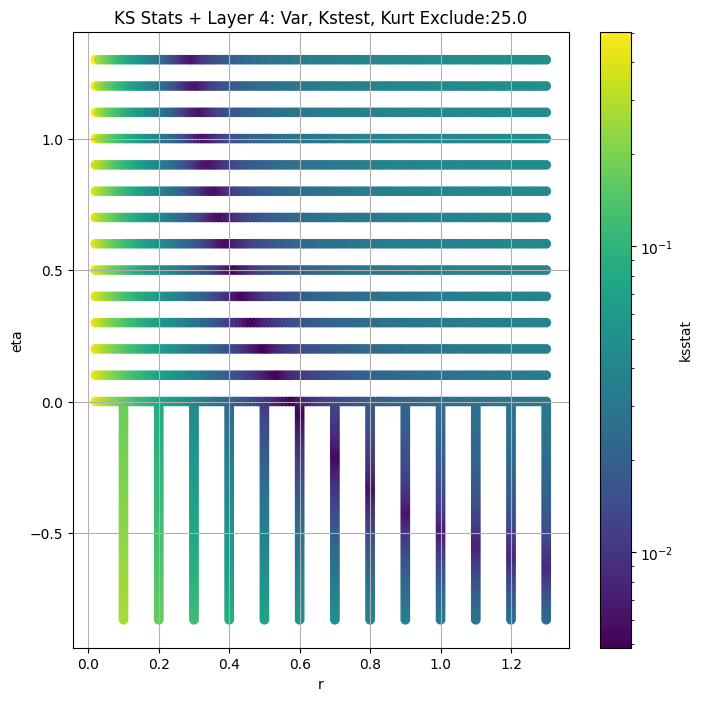

####
Layer  5


100%|██████████| 34762/34762 [07:00<00:00, 82.63it/s] 


Finding Minimum after computing 34762 CDFs
5 0 0.0021255617122832304 37.86353


100%|██████████| 34762/34762 [06:20<00:00, 91.30it/s] 


Finding Minimum after computing 34762 CDFs
5 25 0.0025455477107625413 37.04351


100%|██████████| 34762/34762 [06:01<00:00, 96.14it/s] 


Finding Minimum after computing 34762 CDFs
5 50 0.002815684709275179 36.452328
Number of samples: 100000, Without approximation : 203520.0


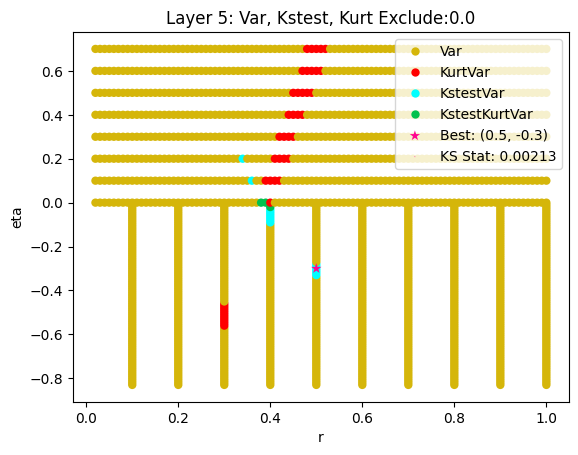

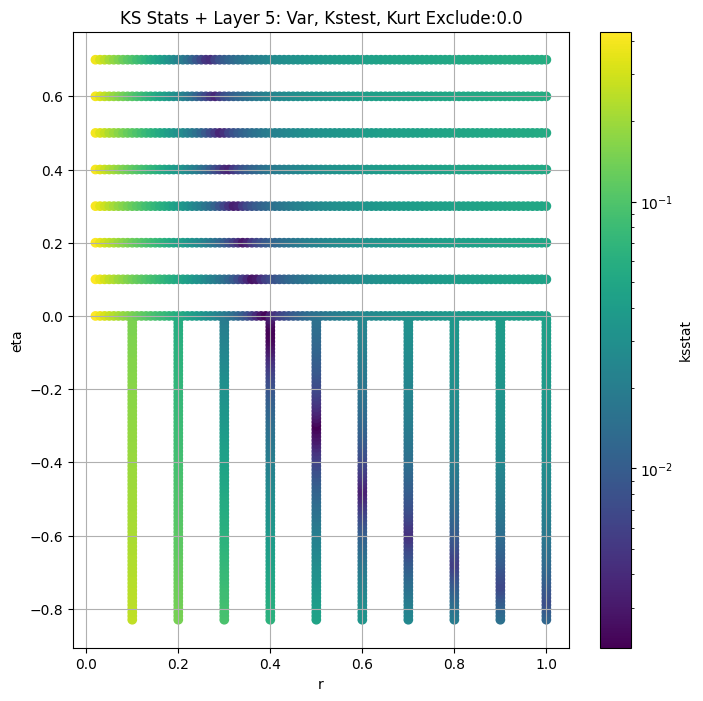

####
Layer  6


100%|██████████| 34762/34762 [09:26<00:00, 61.33it/s] 


Finding Minimum after computing 34762 CDFs
6 0 0.0034804048458575987 7.493805


100%|██████████| 34762/34762 [07:08<00:00, 81.07it/s] 


Finding Minimum after computing 34762 CDFs
6 25 0.0030659576658849663 7.288052


100%|██████████| 34762/34762 [10:35<00:00, 54.69it/s]


Finding Minimum after computing 34762 CDFs
6 50 0.003783076990707901 7.1478653


100%|██████████| 34762/34762 [11:12<00:00, 51.71it/s]


Finding Minimum after computing 34762 CDFs
6 75 0.003973928973766083 7.0289774
Number of samples: 100000, Without approximation : 814080.0


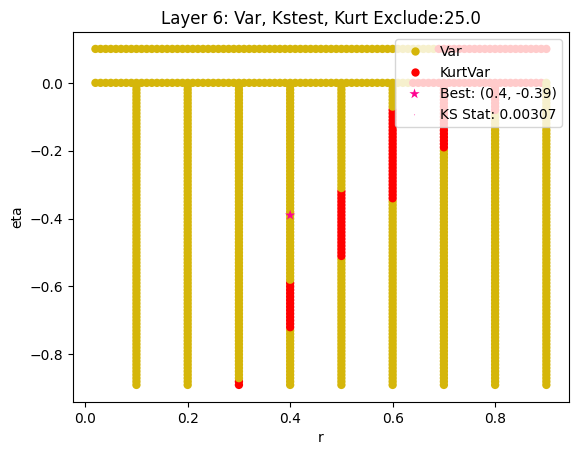

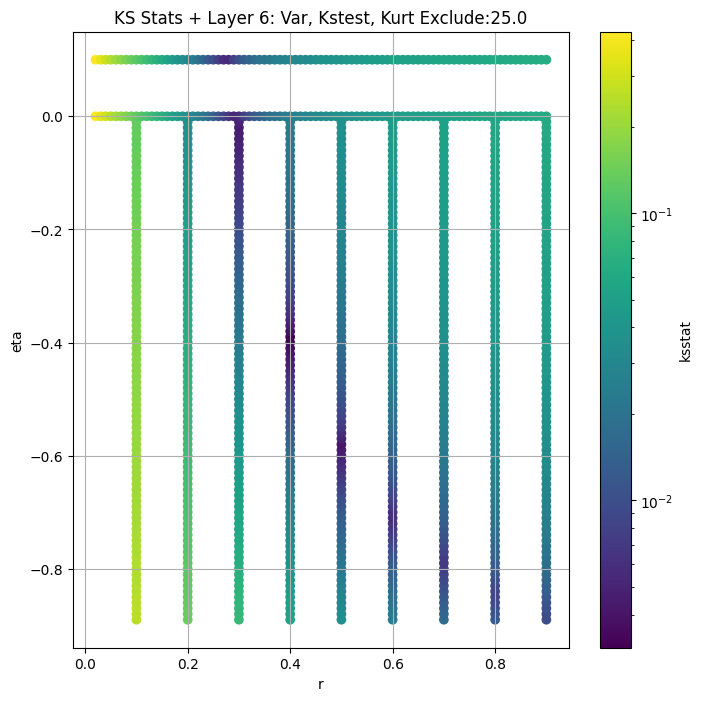

####
Layer  7


100%|██████████| 34762/34762 [11:48<00:00, 49.09it/s]


Finding Minimum after computing 34762 CDFs
7 0 0.00555571268511712 1.3869972


100%|██████████| 34762/34762 [16:29<00:00, 35.14it/s]


Finding Minimum after computing 34762 CDFs
7 25 0.005078245115493596 1.341698


100%|██████████| 34762/34762 [17:51<00:00, 32.45it/s]


Finding Minimum after computing 34762 CDFs
7 50 0.005526718857545632 1.3113118


100%|██████████| 34762/34762 [17:41<00:00, 32.75it/s]


Finding Minimum after computing 34762 CDFs
7 75 0.006116663132887612 1.2856779
Number of samples: 100000, Without approximation : 3256320.0


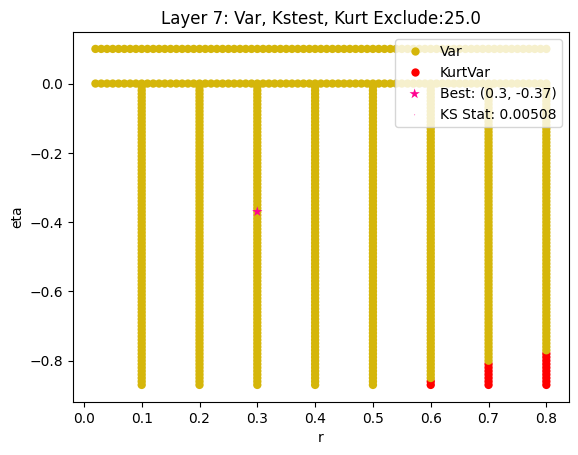

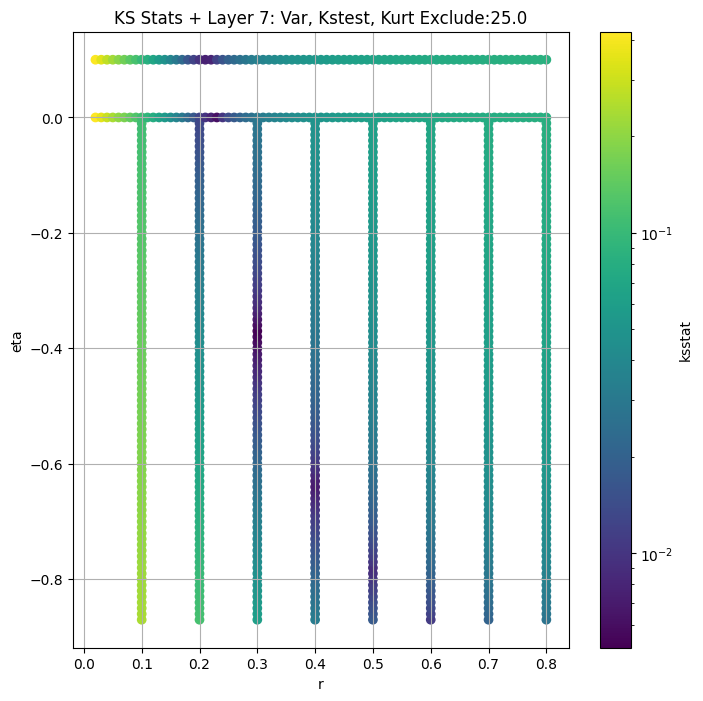

####
Layer  8


100%|██████████| 34762/34762 [17:42<00:00, 32.72it/s]


Finding Minimum after computing 34762 CDFs
8 0 0.006035225463215332 0.21588294


100%|██████████| 34762/34762 [18:03<00:00, 32.09it/s]


Finding Minimum after computing 34762 CDFs
8 25 0.006658080718872084 0.20694143


100%|██████████| 34762/34762 [17:40<00:00, 32.78it/s]


Finding Minimum after computing 34762 CDFs
8 50 0.007018121556567114 0.20154075
Number of samples: 100000, Without approximation : 13025280.0


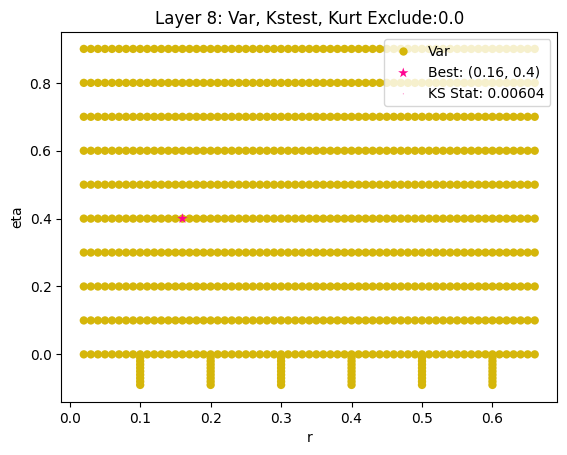

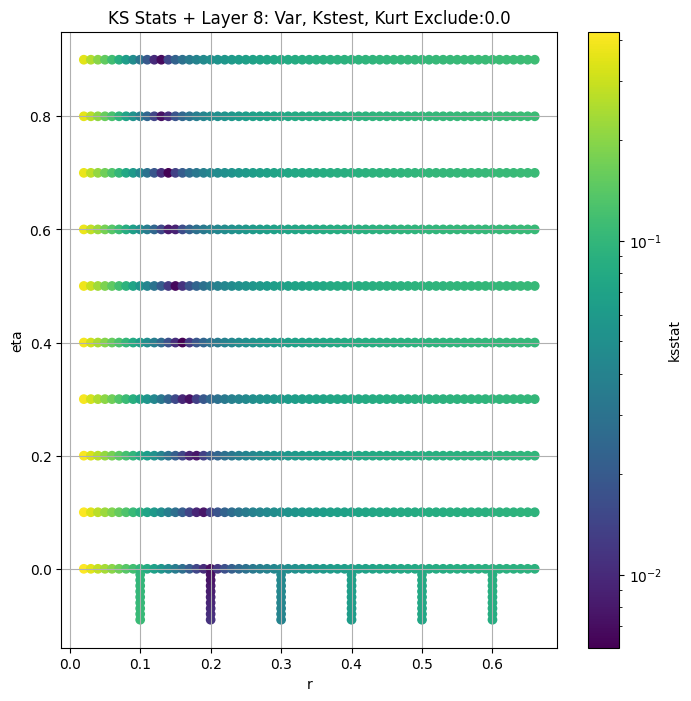

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,best_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,1830.934600,1652.097700,2023.443800,2.933956,1.846394,4.126091,3180.0,0.016937,0.10,9.80,3.660938e-18,0.0,1830.934600,0.024030
3,587.781860,556.332100,620.660600,2.604501,2.026207,3.270645,12720.0,0.004775,0.23,3.40,7.130501e-04,0.0,587.781860,0.012029
4,164.606740,154.984480,174.518840,3.278817,2.623241,4.093916,50880.0,0.004879,0.58,0.00,2.516293e+01,25.0,159.676450,0.006018
5,37.863530,35.388520,40.433693,4.789257,3.843992,5.925406,203520.0,0.002126,0.50,-0.30,4.640138e+00,0.0,37.863530,0.003010
6,7.493805,6.929792,8.083941,6.740130,5.245897,8.892210,814080.0,0.003066,0.40,-0.39,3.268085e-01,25.0,7.288052,0.001505
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0,0.005078,0.30,-0.37,6.965467e-03,25.0,1.341698,0.000753
8,0.215883,0.196152,0.238341,12.285479,8.522737,23.484678,13025280.0,0.006035,0.16,0.40,1.248581e-08,0.0,0.215883,0.000376


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1
        no_improvement_counter = 0

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]

            if no_improvement_counter > 1:
                break

            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if min_stat < master_df.loc[group, 'kstest_stat_initial']:
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
            else:
                no_improvement_counter += 1
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'best_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'best_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

In [13]:
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500,kstest_stat_0,kstest_stat_25,kstest_stat_50,kstest_stat_75
layer,,,,,,,,,,,,,,,,
2,1830.934600,1830.934600,1452.429100,1276.170200,1145.674100,1040.547000,878.686700,749.599240,645.658900,561.035500,489.759500,327.872130,0.016937,0.017617,0.027312,NaN
3,587.781860,587.781860,541.575600,515.132300,493.123140,474.211820,442.020200,414.849430,391.358580,370.649900,351.753480,305.333280,0.004775,0.006796,0.008858,NaN
4,164.606740,164.606740,159.676450,156.378770,153.571080,151.044080,146.518400,142.496200,138.862270,135.548200,132.480400,124.381584,0.004920,0.004879,0.005038,0.005612
5,37.863530,37.863530,37.043510,36.452328,35.938230,35.477500,34.660660,33.947586,33.302437,32.709420,32.163370,30.706472,0.002126,0.002546,0.002816,NaN
6,7.493805,7.493805,7.288052,7.147865,7.028977,6.923156,6.736482,6.573743,6.427655,6.294827,6.172112,5.849966,0.003480,0.003066,0.003783,0.003974
7,1.386997,1.386997,1.341698,1.311312,1.285678,1.262962,1.223419,1.189016,1.158356,1.130505,1.104886,1.037957,0.005556,0.005078,0.005527,0.006117
8,0.215883,0.215883,0.206941,0.201541,0.197070,0.193155,0.186390,0.180575,0.175420,0.170760,0.166490,0.155441,0.006035,0.006658,0.007018,NaN


## Optimization

In [14]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(-50, 51, 10)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']

                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                group_cdfs = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                group_cdfs_df = create_kurt_var_ksstat_df(group_cdfs)

                for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                    exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'best_exclude_cutoff']))
                    
                    if exclude_cutoff == 0:
                        augmented_var = np.var(group_data_map[group])
                    else:
                        augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                    group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                    ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                    
                    cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                    augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                    group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                    
                    print(group, adjust_exclude_cutoff, exclude_cutoff, min_stat, augmented_var, cutoff_label)
                    best_adjust = 0

                    if min_stat < master_df.loc[group, 'kstest_stat_best']:

                        inital_min_stat = min_stat
                        inital_best_param = initial_param
                        master_df.loc[group, 'kstest_stat_best'] = min_stat
                        initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                        master_df.loc[group, 'best_scale'] = initial_scale
                        master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                        master_df.loc[group, 'best_augmented_var'] = augmented_var
                        augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                        best_adjust = adjust_exclude_cutoff

                cutoff_label = generate_cutoff_label(best_adjust)
                ksstats = group_cdfs_df[f"ksstat_exclude_{best_adjust}"]
                
                print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
                
                cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
                master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

                best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

                group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
                group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

                group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

                group_dict = rEtaKsstats_dict[group]
                group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
                rEtaKsstats_dict[group] = group_dict

                print(f"Iter {d} {GROUP} {group} best parameters: {master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'], master_df.loc[group, 'best_scale'], master_df.loc[group, 'best_exclude_cutoff'], master_df.loc[group, f'kstest_stat_best']}")

            filtered_df = group_cdfs_df[(group_cdfs_df['r'] > master_df.loc[group, 'initial_r'] - r_granularity) & 
                            (group_cdfs_df['r'] < master_df.loc[group, 'initial_r'] + r_granularity) &
                            (group_cdfs_df['eta'] > master_df.loc[group, 'initial_eta'] - eta_granularity) &
                            (group_cdfs_df['eta'] < master_df.loc[group, 'initial_eta'] + eta_granularity)]
            
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

Layer 2


## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df

In [ ]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))